In [14]:
import pandas as pd

df=pd.read_csv('FinalData.csv')

In [15]:
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

T    TM   Tm     SLP   H   VV    V    VM      PM 2.5
0   7.4   9.8  4.8  1017.6  93  0.5  4.3   9.4  219.720833
1   7.8  12.7  4.4  1018.5  87  0.6  4.4  11.1  182.187500
2   6.7  13.4  2.4  1019.4  82  0.6  4.8  11.1  154.037500
3   8.6  15.5  3.3  1018.7  72  0.8  8.1  20.6  223.208333
4  12.4  20.9  4.4  1017.3  61  1.3  8.7  22.2  200.645833

In [16]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [33]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor(criterion="mse")
dtree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [40]:
print("Coefficient of determination R^2 <-- on train set: {}".format(dtree.score(X_train, y_train)))
print("Coefficient of determination R^2 <-- on test set: {}".format(dtree.score(X_test, y_test)))

Coefficient of determination R^2 <-- on train set: 1.0
Coefficient of determination R^2 <-- on test set: 0.15885761505694018


In [41]:
# Calculate Cross-validation score
from sklearn.model_selection import cross_val_score
score=cross_val_score(dtree,X,y,cv=5)

score.mean()

0.023730140979017267

# Visualization

In [37]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

In [31]:
features = list(df.columns[:-1])
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.845491 to fit



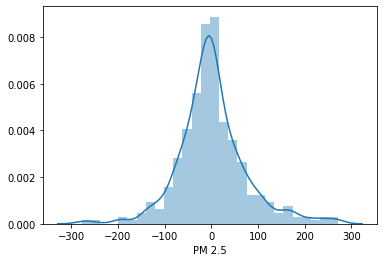

In [38]:
prediction=dtree.predict(X_test)
sns.distplot(y_test-prediction)

# HyperParameter Tuning

In [42]:
# We tune some of the hyperParameters for the decision tree model to get a better performance in the test dataset

params = {
    "splitter"    : ["best","random"] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_samples_leaf" : [ 1,2,3,4,5 ],
"min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
 "max_features" : ["auto","log2","sqrt",None ],
    "max_leaf_nodes":[None,10,20,30,40,50,60,70]
}

In [43]:
# Hyperparameter optimization using GridSearchCV
from sklearn.model_selection import GridSearchCV

random_search=GridSearchCV(dtree,param_grid=params,scoring='neg_mean_squared_error',n_jobs=-1,cv=10,verbose=3)

In [45]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

start_time = timer(None)
random_search.fit(X,y)
timer(start_time)

Fitting 10 folds for each of 10240 candidates, totalling 102400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5912 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 10520 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 16152 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 22808 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 30488 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 39192 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 48920 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 59672 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 71448 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 84248 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 98072 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10240


 Time taken: 0 hours 1 minutes and 20.12 seconds.


In [46]:
# The set of parameters that perform the best are:
random_search.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 4,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'random'}

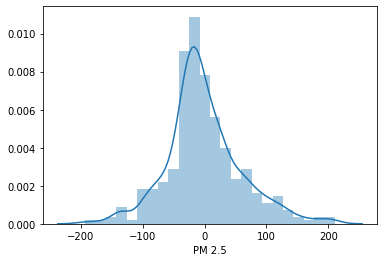

In [47]:
predictions=random_search.predict(X_test)

sns.distplot(y_test-predictions)

In [49]:
from sklearn import metrics
import numpy as np

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 51.61943170234455
MSE: 5515.48272431405
RMSE: 74.26629601854431
